# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [33]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [34]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

os.mkdir('/content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O /content/data/data.zip
!unzip "/content/data/data.zip" -d "/content/"
os.system("rm /content/data/data.zip")
data_dir = '/content/data/'


--2024-04-26 03:45:10--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 173.194.215.138, 173.194.215.100, 173.194.215.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2024-04-26 03:45:10--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘/content/data/data.zip’

/content/data/data. 100%[===================>]   5.92M 

Utils Functions.

In [35]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

1. In Fig 2a, $dA$ stands for a tiny aera of the surface, the vector $\vec{v}$ stands for the viewing direction and vector $\vec{l}$ stands for the direction of the light. Vector $\vec{n}$ stands for the normal direction of the surface. Depends on the the normal direction of the lighting area and the direction of the light, the object will have different luminance effect.
2. $\vec{l}\cdot\vec{n}$ stands for the dot product of light direction and normal direction of the lighting aera. It means the alignment of the two vector and represents the intensity of light absorbed or reflected by the surface.
3. If we use $\mathbf{S}$ stands for the area, then $\frac{\mathbf{S}_{project}}{\mathbf{S}_{original}} = \vec{l}\cdot\vec{n} = \|l\|\|n\|\cos \theta$. If $\vec{l}\cdot\vec{n}=0$, it means light direction is perpendicular with normal direction, there is no project area. If $\vec{l}\cdot\vec{n} = 1$, it means light direction is aligned with normal direction, then the project area is the same as original area.
4. Since we are assuming that we use orthographic camera, it means the viewing direction would not affect the luminance of the pixel, only the light direction and normal direction will do.

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

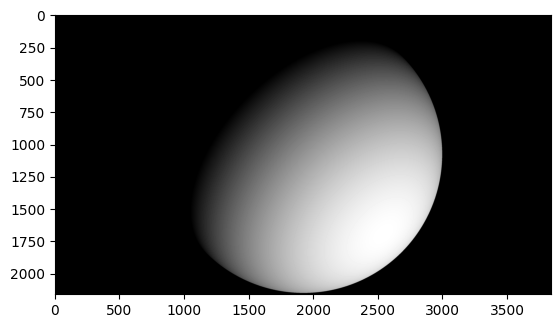

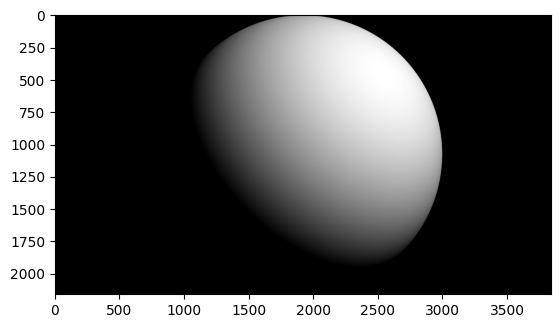

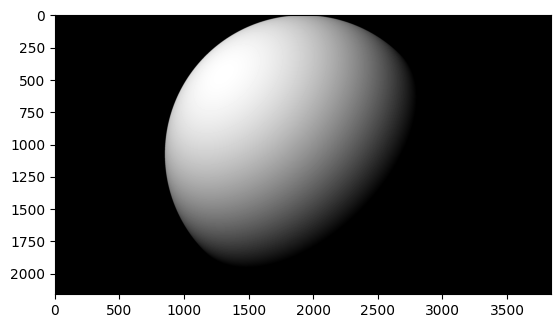

In [36]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None
    ### YOUR CODE HERE
    image = np.zeros((res[1], res[0]))
    # normal direction
    N = np.dstack((X, Y, Z)) - center
    norm = np.linalg.norm(N, axis=2)
    norm[norm == 0] = np.finfo(float).eps
    N /= np.expand_dims(norm, axis=-1)

    # light direction
    L = np.array(light)
    L /= np.linalg.norm(L)

    # n dot l
    NdotL = np.sum(N * L, axis=2)

    brightness = np.clip(NdotL, 0, None)
    image[Z>0] = brightness[Z>0]
    image -= image.min()
    image /= image.max()
    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [37]:
### YOUR CODE HERE
def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

I, L, s = loadData(data_dir)
U, S, Vt = np.linalg.svd(I, full_matrices=False)
print(S)
### END YOUR CODE

[79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

As shown above, the singular value decomposition, which is the rank of $\mathbf{I}$ is 3. This is because the luminance of the surface can be presented by three non linear-related vectors, which is what we discussed in part(a).

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [38]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    # calculate matrix A and vector y using L and I
    A = spkron(L.T, speye(I.shape[1]))
    y = I.flatten()

    # least square method
    B = splsqr(A, y)[0]

    # reshape matrix B to 3xP
    B = B.reshape(3, I.shape[1])
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

Matrix $\mathbf{A}$ is calculated with kronecher product from matrix $\mathbf{I}$ and vector $\mathbf{y}$ is the vector form of luminance $\mathbf{I}$.

---


### Q 1 (e) Albedos and normals (10 points)

---

In albedo image, the area of eyebrows, eyelashes, and lips, are apparently darker than other face areas. This is likely because these areas absorb more light than other features so that they appear to be darker. Other darker areas like left half of the face more darker than left half of the face are likely to caused by shadows and possible noise of the image(caused by shadow either).

---

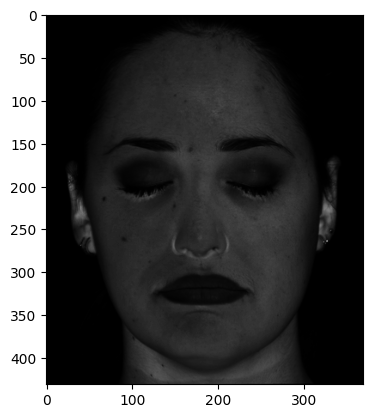

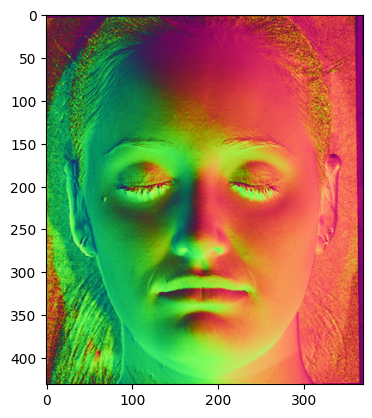

In [40]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE
    # albedos are the magnitudes of the pseudonormals
    albedos = np.linalg.norm(B, axis=0)

    # pseudonormals divided by magnitudes
    normals = B / albedos
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

The normal to the surface which is $\mathbf{n}=(n_1, n_2, n_3)$ is orthogonal to the tangent plane of the surface at point $(x,y)$. Hence we have:
$$\mathbf{n}\cdot(1,0,f_x)=n_1+n_3f_x=0$$
$$\mathbf{n}\cdot(0,1,f_x)=n_2+n_3f_x=0$$
From this we can calculate the deirivatives of $f$ at $(x,y)$ is:
$$f_x=\dfrac{\partial f}{\partial x}=-\dfrac{n_1}{n_3}$$
$$f_y=\dfrac{\partial f}{\partial y}=-\dfrac{n_2}{n_3}$$

---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

1. Clealy as shown below, the reconstructed g from two procedures are not the same. We have:
$$g_1 = \begin{bmatrix}1 & 2 & 3 &4 \\ 1 & 6 & 7 & 8 \\ 1 & 10 & 11 & 12 \\ 1 & 14 & 15 & 16\end{bmatrix}$$
$$g_2 = \begin{bmatrix}1 & 1 & 1 & 1 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16\end{bmatrix}$$
2. To make $g_x$ and $g_y$ non-integrable, we need to make $g_{xy}=g_{yx}$, which is to say, $\frac{\partial^2 f}{\partial y \partial x} = \frac{\partial^2 f}{\partial x \partial y}$.
3. Because we use finite differences to calculate gradients, we are assuming that points are linearly approximate.


---

### Q 1 (h): Shape estimation (10 points)

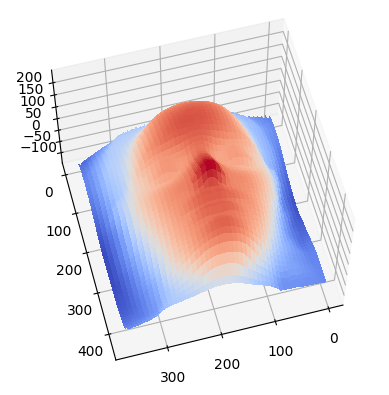

In [60]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    dx = normals[0] /- normals[2]
    dy = normals[1] /- normals[2]
    dx, dy = dx.reshape(s), dy.reshape(s)
    surface = integrateFrankot(dx, dy)
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)

# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

Since we know the rank of $\mathbf{I}$ is 3, we can use perform SVD on $\mathbf{I}$, so that $\mathbf{I}=\mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$. Then we set all singular values except the top 3 from $\mathbf{\Sigma}$ to 0 to get the matrix $\mathbf{\hat{\Sigma}}$, and we reconstitude the $\mathbf{\hat{I}}=\mathbf{U}\mathbf{\hat\Sigma}\mathbf{V}^T$.

---

### Q 2 (b): Calculation and visualization (10 points)

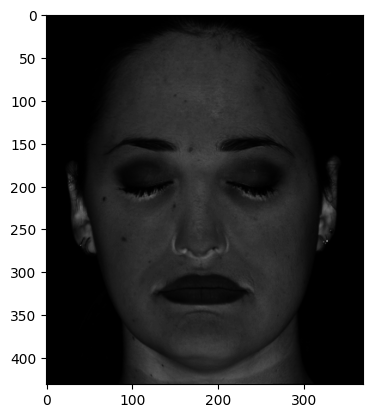

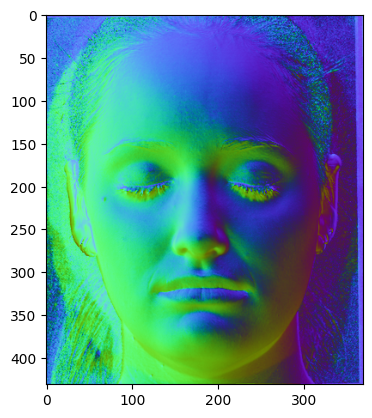

In [61]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	# perform SVD
	u, s, v = np.linalg.svd(I, full_matrices=False)

	# keep the first 3 singular value
	s[3:] = 0.

	# construct B and L
	B = v[:3]
	Lt = u[:, :3] * s[:3]
	L = Lt.T
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

The $\mathbf{\hat{L}}$ esimated and ground truth lighting direction in Q1 are different. \\
Put any scale factor to $\mathbf{\hat{L}}$ and $\mathbf{\hat{B}}$ would not change the imaged rendered.

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

Apparently not like a face.

---

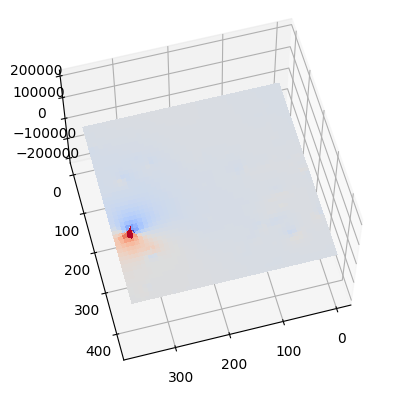

In [19]:
# Part 2 (d)
### YOUR CODE HERE
albedos, normals = estimateAlbedosNormals(B)
surface = estimateShape(normals, s)
plotSurface(surface)
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

The surface looks like the output by calibrated photometric stereo.

---


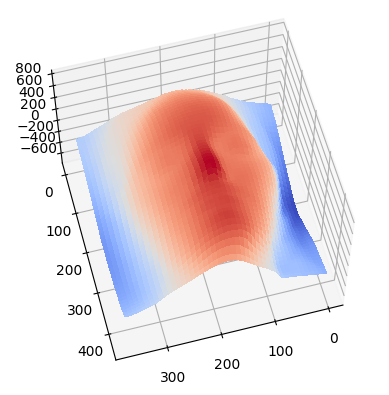

In [63]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE
albedos, normals = estimateAlbedosNormals(B)
normals = enforceIntegrability(normals, s)
surface = estimateShape(normals, s)
plotSurface(surface)
### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

We use $[𝜇, 𝜈, λ] = [0, 0, 1]$ as the baseline, first vary $𝜇$ from 1 to 20, then vary $𝜈$ from 1 to 20, then vary $λ$ from 0.1 to 20. \\
1. The variation of $𝜇$ indicates that larger $𝜇$ makes the surface tilt toward x-positive direction.
2. The variation of $𝜈$ indicates that larger $𝜈$ makes the surface tilt toward x-negative direction.
3. The variation of $λ$ indicates that $λ$ controls the z direction gap of the surface. The larger $λ$ becomes, the larger z direction gap becomes.

---

<IPython.core.display.Javascript object>

[[ 1.  0. -1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
mu=1, nu=0, lam=1


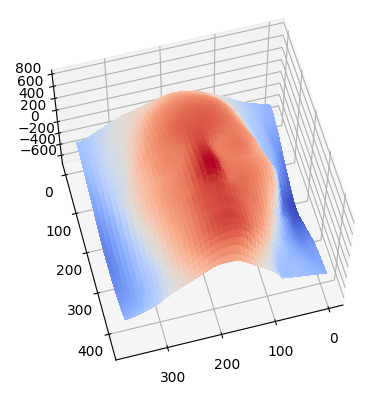

[[  1.   0. -20.]
 [  0.   1.  -0.]
 [  0.   0.   1.]]
mu=20, nu=0, lam=1


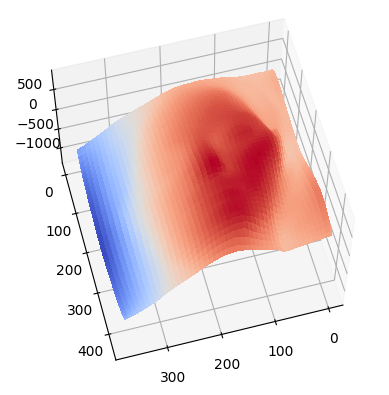

[[ 1.  0.  0.]
 [ 0.  1. -1.]
 [ 0.  0.  1.]]
mu=0, nu=1, lam=1


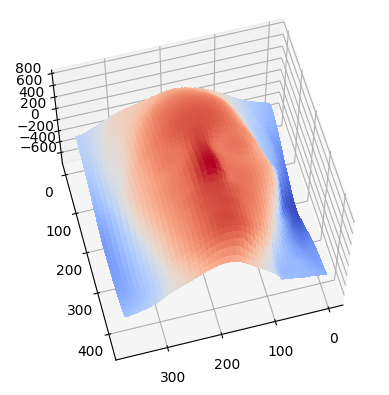

[[  1.   0.  -0.]
 [  0.   1. -20.]
 [  0.   0.   1.]]
mu=0, nu=20, lam=1


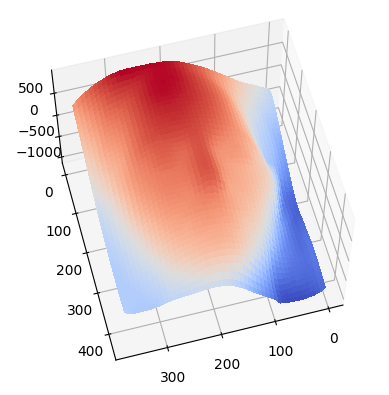

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. 10.]]
mu=0, nu=0, lam=0.1


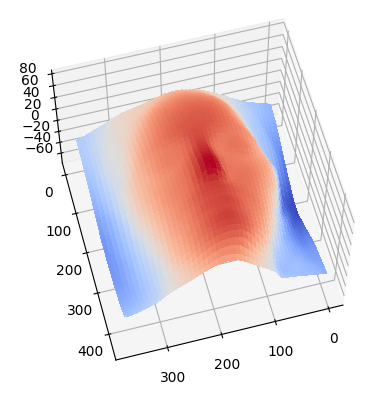

[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   0.05]]
mu=0, nu=0, lam=20


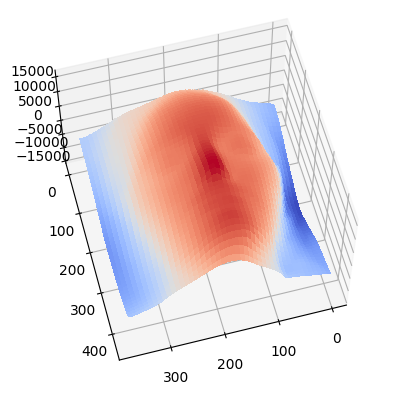

In [78]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE
# vary mu
for mu in [1, 20]:
  nu = 0
  lam = 1
  G = np.array([[1, 0, 0], [0, 1, 0], [mu, nu, lam]])
  G = (np.linalg.inv(G)).T
  print(G)
  print(f'mu={mu}, nu={nu}, lam={lam}')
  albedos, normals = estimateAlbedosNormals(B)
  normals = enforceIntegrability(normals, s)
  normals = G @ normals

  surface = estimateShape(normals, s)
  plotSurface(surface)

# vary nu
for nu in [1, 20]:
  mu = 0
  lam = 1
  G = np.array([[1, 0, 0], [0, 1, 0], [mu, nu, lam]])
  G = (np.linalg.inv(G)).T
  print(G)
  print(f'mu={mu}, nu={nu}, lam={lam}')
  albedos, normals = estimateAlbedosNormals(B)
  normals = enforceIntegrability(normals, s)
  normals = G @ normals

  surface = estimateShape(normals, s)
  plotSurface(surface)

# vary lam
for lam in [0.1, 20]:
  mu = 0
  nu = 0
  G = np.array([[1, 0, 0], [0, 1, 0], [mu, nu, lam]])
  G = (np.linalg.inv(G)).T
  print(G)
  print(f'mu={mu}, nu={nu}, lam={lam}')
  albedos, normals = estimateAlbedosNormals(B)
  normals = enforceIntegrability(normals, s)
  normals = G @ normals

  surface = estimateShape(normals, s)
  plotSurface(surface)
### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

Clearly we just make $λ$ as small as possible, maybe 0.001 or even 0.0001.

---

### Q 2 (h): More measurements

---

No, it is not helpful for solve the ambiguity since the factorization of the image matrix $\mathbf{I}=\mathbf{L}^T\mathbf{B}$ is remained here.

---